# Libraries

In [1]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import math

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

%matplotlib ipympl
# %matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [2]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, digital_hw_algo as dighw, rf_estimation as rf_est

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(dighw)
reload(rf_est)

<module 'rfdsppy.rf_estimation' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rf_estimation.py'>

# Complex OFDM waveform

(-100.0, 8.88274780109938)

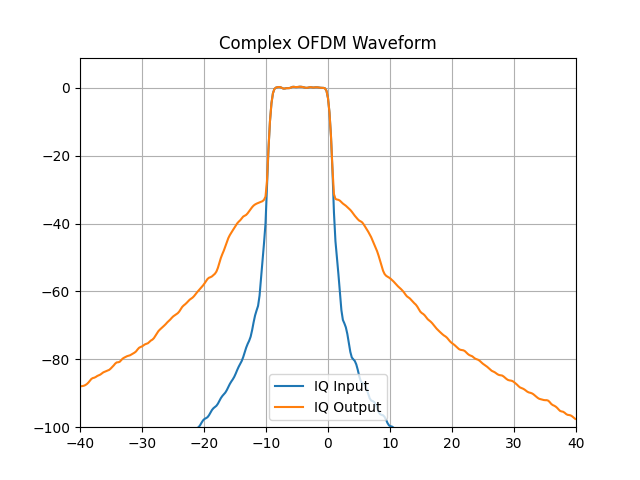

In [48]:
bw = 20
scs = 15
start_sc = 0
num_sc = 12*50

wg = ofdm.OFDMWavGen(bw, scs, 4, start_sc, num_sc=num_sc, osr=16)
cfg = wg.get_demod_params()
fs = cfg.get("fs")

pa = rf_analog.RappSaleh(cfg={
        "g": 10**(30/20),
        "smoothness": 2,
        "osat": 24,
        "a": 1,
        "b": 30,
})
x, x_standard = wg.generate(14)
x = x/np.abs(x).max()
y = pa.transform(x)

# comp = calc.comp_db(x, y, cfg={"en_plot": True})
# print(comp)
px, f = calc.psd(x, fs, fs/2048)
py, _ = calc.psd(y, fs, fs/2048)
px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)
py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)

fig, ax = plt.subplots(dpi=100)

ax.plot(f, 10*np.log10(px), label="IQ Input")
ax.plot(f, 10*np.log10(py), label="IQ Output")
ax.grid()
ax.legend(loc="lower center")
ax.set_title("Complex OFDM Waveform")
ax.set_xlim(left=-40, right=40)
ax.set_ylim(bottom=-100)

# Baseband harmonics

(-150.0, 9.246208575616825)

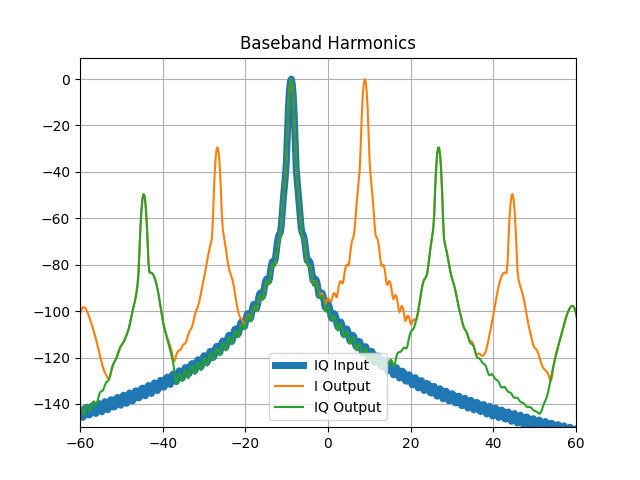

In [56]:
bw = 20
scs = 15
start_sc = 0
num_sc = 12

wg = ofdm.OFDMWavGen(bw, scs, 4, start_sc, num_sc=num_sc, osr=16)
cfg = wg.get_demod_params()
fs = cfg.get("fs")

pa = rf_analog.RappSaleh(cfg={
        "g": 10**(30/20),
        "smoothness": 2,
        "osat": 24,
        "a": 1,
        "b": 30,
})
x, x_standard = wg.generate(14)
x = x/np.abs(x).max()
y_real = pa.transform(x.real)
y_imag = pa.transform(x.imag)
y = y_real + 1j*y_imag

px, f = calc.psd(x, fs, fs/2048)
py_real, _ = calc.psd(y_real, fs, fs/2048)
py, _ = calc.psd(y, fs, fs/2048)
px = calc.scale_psd(px, f, bw, scs, start_sc, num_sc)
py_real = calc.scale_psd(py_real, f, bw, scs, start_sc, num_sc)
py = calc.scale_psd(py, f, bw, scs, start_sc, num_sc)

fig, ax = plt.subplots(dpi=100)

ax.plot(f, 10*np.log10(px), label="IQ Input", linewidth=5)
ax.plot(f, 10*np.log10(py_real), label="I Output")
ax.plot(f, 10*np.log10(py), label="IQ Output")
ax.grid()
ax.legend(loc="lower center")
ax.set_title("Baseband Harmonics")
ax.set_xlim(left=-60, right=+60)
ax.set_ylim(bottom=-150)

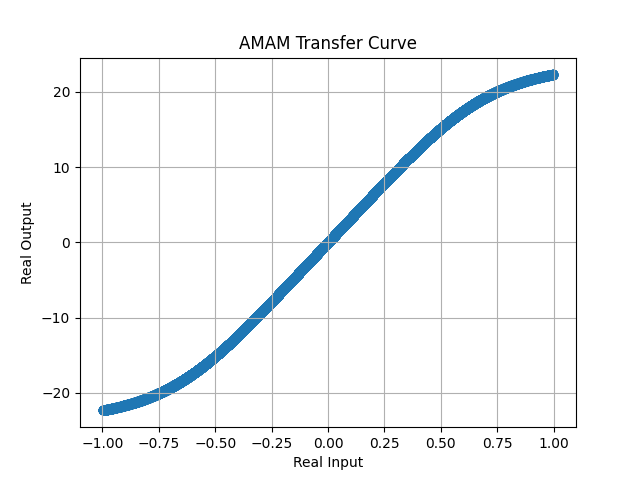

In [57]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(x.real, y_real.real)
ax.set_title("AMAM Transfer Curve")
ax.set_xlabel("Real Input")
ax.set_ylabel("Real Output")
ax.grid()

# Discrete complex tones

(-150.0, 12.568219208329328)

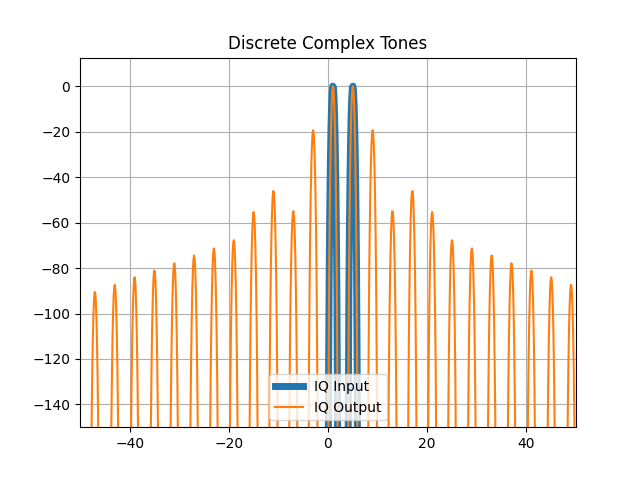

In [67]:
bw = 20
scs = 15
start_sc = 0
num_sc = 12*50

wg = ofdm.OFDMWavGen(bw, scs, 4, start_sc, num_sc=num_sc, osr=8)
cfg = wg.get_demod_params()
fs = cfg.get("fs")

pa = rf_analog.RappSaleh(cfg={
        "g": 10**(30/20),
        "smoothness": 2,
        "osat": 24,
        "a": 1,
        "b": 30,
})
# x, x_standard = wg.generate(14)

x = np.exp(1j*2*np.pi/fs*np.arange(2**16, dtype="float")) + np.exp(1j*5*2*np.pi/fs*np.arange(2**16, dtype="float")) #+ np.exp(1j*3*2*np.pi/fs*np.arange(2**16, dtype="float"))
x = x/np.abs(x).max()
y = pa.transform(x)

# comp = calc.comp_db(x, y, cfg={"en_plot": True})
# print(comp)
px, f = calc.psd(x, fs, fs/2048)
py, _ = calc.psd(y, fs, fs/2048)
px = px/px.max()
py = py/py.max()

fig, ax = plt.subplots(dpi=100)

ax.plot(f, 10*np.log10(px), label="IQ Input", linewidth=5)
ax.plot(f, 10*np.log10(py), label="IQ Output")
ax.grid()
ax.legend(loc="lower center")
ax.set_title("Discrete Complex Tones")
ax.set_xlim(left=-50, right=50)
ax.set_ylim(bottom=-150)